## Twitter Sentiment Analysis

**Problem statement:** Airline industry had a very hard time post covid to sustain their business due to a long hault. It is very important for them to make sure they exceed customer expectations. The best way to evaluate performance is customer feedback. You are given a dataset of airline tweets from real customers.

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

You will use the text column and sentiment column to create a classification model that classifies a given tweet into one of the 3 classes - positive, negative, neutral.

**Understanding the Dataset:**

Dataset contains many columns out of which below are most important ones-
1. airline_sentiment - defines the sentiment of the tweet
2. negative_reason - reason for the negative feedback (if negative)
3. Text - tweet text content
4. tweet_location - location from which tweet was posted

You can use more columns in your model training if you want.


**Steps to perform**
1. Load dataset - https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
2. Clean, preprocess data and EDA
3. Vectorise columns that contain text
4. Run Classification model to classify - positive, negative or neutral
5. Evaluate model



### Setup

In [63]:
import pandas as pd
import numpy as np
import random

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib as mpl
from matplotlib import pyplot as plt

import spacy
from spacy.pipeline.textcat import Config , single_label_default_config, single_label_bow_config, single_label_cnn_config
from spacy.training import Example
from spacy.util import minibatch

from tqdm.notebook import tqdm
import math

from sklearn.metrics import classification_report

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [2]:

def init_pipe(model_name, labels):
    config = Config().from_str(model_name)
    pipe = spacy.blank("en")
    classifier = pipe.add_pipe("textcat", config=config, last=True)
    for label in labels:
        classifier.add_label(label)

    return pipe

def train(nlp_pipe, train_data, test_data, batch_size, epochs, drop_prc=None):
    optimizer = nlp_pipe.begin_training()
    info = {"train_losses": [], "train_accs": [], "test_accs": []}

    # loop over epochs
    for i in tqdm(range(epochs)):
        random.shuffle(train_data)
        loss = {}

        # training loop
        for batch in tqdm(minibatch(train_data, size=batch_size), total=math.ceil(len(train_data) / batch_size)):
            texts_batch = [nlp_pipe.make_doc(text) for text, labels in batch]
            labels_batch = [{"cats": labels} for text, labels in batch]

            examples = [Example.from_dict(doc, label) for doc, label in zip(texts_batch, labels_batch)]
            nlp_pipe.update(examples, losses=loss, sgd=optimizer, drop=drop_prc)

        # evaluation
        train_target_labels = [list(x[1].keys())[0] for x in train_data]
        test_target_labels = [list(x[1].keys())[0] for x in test_data]
        train_pred_labels = predict(nlp_pipe, train_data)
        test_pred_labels = predict(nlp_pipe, test_data)
        train_acc = accuracy(train_target_labels, train_pred_labels)
        test_acc = accuracy(test_target_labels, test_pred_labels)

        # collect metrics
        info["train_losses"].append(loss["textcat"])
        info['train_accs'].append(train_acc)
        info["test_accs"].append(test_acc)
        
        print(f"[INFO] Train Loss: {loss['textcat']:.4f} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%}")

    return nlp_pipe, info


def predict(nlp_pipe, data):
    classifier = nlp_pipe.get_pipe("textcat")
    probs = classifier.predict([nlp_pipe.make_doc(x[0]) for x in data])
    preds = np.argmax(probs, axis=-1)
    pred_labels = [classifier.labels[p] for p in preds]

    return pred_labels


def accuracy(target_labels: list[str], pred_labels: list[str]):
    accuracy = np.array([target == pred for target, pred in zip(target_labels, pred_labels)]).mean()
    return accuracy

def plot_accuracy(info: dict):
    plt.figure(figsize=(8, 4), dpi=100)
    plt.plot(info["train_accs"], label="Train Acc")
    plt.plot(info["test_accs"], label="Test Acc")
    plt.legend()
    plt.show()

def plot_confmatrix(targets: list[str], preds: list[str], label_names: list[str] = None,):
    mpl.rc_file_defaults()
    fig, ax = plt.subplots(dpi=100)
    
    label_font = {'size':'18'}  # Adjust to fit


    ConfusionMatrixDisplay.from_predictions(
        targets,
        preds,
        display_labels=label_names,
        cmap='Oranges',
        ax=ax
    )

    plt.xticks(rotation=90)

    plt.show()

### Load data & EDA

In [15]:
CSV_PATH = "./Tweets.csv"

df = pd.read_csv(CSV_PATH)

In [16]:
print(df.shape)
df.head()

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [17]:
pysqldf("select count(*) as cnt, count(distinct tweet_id) as dist_cnt from df")

,cnt,dist_cnt
0,14640,14485


In [18]:
labels = pysqldf("select distinct airline_sentiment from df order by 1")["airline_sentiment"].tolist()
labels

['negative', 'neutral', 'positive']

In [19]:
query = """
select
    airline_sentiment
    , count(*) as cnt
from df
group by 1
order by 2 desc
""".strip()

pysqldf(query)

,airline_sentiment,cnt
0,negative,9178
1,neutral,3099
2,positive,2363


In [20]:
query = """
select
    negativereason
    , count(*) as count
from df
where airline_sentiment = "negative"
group by 1
order by 2 desc
""".strip()

pysqldf(query)

,negativereason,count
0,Customer Service Issue,2910
1,Late Flight,1665
2,Can't Tell,1190
3,Cancelled Flight,847
4,Lost Luggage,724
5,Bad Flight,580
6,Flight Booking Problems,529
7,Flight Attendant Complaints,481
8,longlines,178
9,Damaged Luggage,74


In [21]:
query = """
select
    airline
    , count(*) as cnt
from df
group by 1
order by 1
""".strip()

pysqldf(query)

,airline,cnt
0,American,2759
1,Delta,2222
2,Southwest,2420
3,US Airways,2913
4,United,3822
5,Virgin America,504


In [22]:
pysqldf("select count(*), count(distinct tweet_id) from df")

,count(*),count(distinct tweet_id)
0,14640,14485


In [23]:
query = """
with t1 as (
select
    airline
    , count(distinct tweet_id) as total
    , count(distinct case when airline_sentiment = "negative" then tweet_id else null end) as negative_cnt
    , count(distinct case when airline_sentiment = "neutral" then tweet_id else null end) as neutral_cnt
    , count(distinct case when airline_sentiment = "positive" then tweet_id else null end) as positive_cnt
from df
group by 1
order by 1
)

select
    airline
    , round(100. * negative_cnt / total, 2) as negative_prc
    , round(100. * neutral_cnt / total, 2) as neutral_prc
    , round(100. * positive_cnt / total, 2) as positive_prc
from t1
""".strip()

pysqldf(query)

,airline,negative_prc,neutral_prc,positive_prc
0,American,71.85,16.82,12.02
1,Delta,42.98,32.54,24.48
2,Southwest,49.01,27.44,23.55
3,US Airways,77.69,13.08,9.23
4,United,68.89,18.24,12.87
5,Virgin America,35.91,33.93,30.16


In [24]:
query = """
select
    airline_sentiment
    , round(avg(airline_sentiment_confidence), 2) as avg_sentiment_confidence
from df
group by 1
order by 1
""".strip()

pysqldf(query)

,airline_sentiment,avg_sentiment_confidence
0,negative,0.93
1,neutral,0.82
2,positive,0.87


In [25]:
query = """
select
    distinct airline
from df
order by 1
""".strip()

pysqldf(query)

,airline
0,American
1,Delta
2,Southwest
3,US Airways
4,United
5,Virgin America


In [27]:
query = """
select
    count(*) as cnt
    , count(distinct text) cnt_dist
from df
""".strip()

pysqldf(query) 

,cnt,cnt_dist
0,14640,14427


### Preprocessing

#### Remove duplicates

In [29]:
df = df.drop_duplicates(subset=["tweet_id"], keep="first", inplace=False, ignore_index=True)
pysqldf("select count(*) as cnt, count(distinct tweet_id) as dist_cnt from df")

,cnt,dist_cnt
0,14485,14485


In [30]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


#### Keep only essential columns for text classification

In [31]:
data = pysqldf("select distinct tweet_id, text, airline_sentiment from df")
data.head()

,tweet_id,text,airline_sentiment
0,570306133677760513,@VirginAmerica What @dhepburn said.,neutral
1,570301130888122368,@VirginAmerica plus you've added commercials t...,positive
2,570301083672813571,@VirginAmerica I didn't today... Must mean I n...,neutral
3,570301031407624196,@VirginAmerica it's really aggressive to blast...,negative
4,570300817074462722,@VirginAmerica and it's a really big bad thing...,negative


#### Shuffle

In [32]:
data_shuffled = data.sample(frac=1, random_state=None)
data_shuffled.head(10)

for index, row in data_shuffled.head().iterrows():
    print(f"Text: {row['text']}\nSentiment: {row['airline_sentiment']}\n")

Text: @SouthwestAir Amazing customer service as well. Will definitely fly with you guys again if my instrument is involved. #10/10
Sentiment: positive

Text: @SouthwestAir thanks for an awesome flight and connection! We were delayed but your staff and crew were purely amazing!
Sentiment: positive

Text: @AmericanAir Am on web site requesting refund for Cancelled Flightled flight. It requires numerical document number. Where get it?
Sentiment: neutral

Text: @SouthwestAir booked the 8th.... Save me an emergency exit... Gotta stretch out
Sentiment: neutral

Text: @JetBlue I’m going to miss a hugely important meeting because of your constant delays #itscostingmeincome
Sentiment: negative



#### Clean text

In [33]:
text_cleaned = []
text = data_shuffled["text"].tolist()
# nlp_preprocess = spacy.load("en_core_web_sm", disable=["ner"])
nlp_preprocess = spacy.blank("en")

for record in text:
    doc = nlp_preprocess(record)
    tokens = [token for token in doc]
    filtered_tokens = [token for token in tokens if not token.is_punct and not str(token).startswith("@") and not str(token).startswith("http://")]
    doc_cleaned = spacy.tokens.Doc(nlp_preprocess.vocab, words=[token.text for token in filtered_tokens]).text.strip()
    text_cleaned.append(doc_cleaned)

    # lemmas = [token.lemma_ for token in filtered_tokens]
    # vectors = [token.vector for token in filtered_tokens]

data_shuffled["text_cleaned"] = text_cleaned
data_shuffled["len"] = data_shuffled["text_cleaned"].apply(lambda x: len(x.split()))
data_shuffled[["text", "text_cleaned", "airline_sentiment"]].head()

,text,text_cleaned,airline_sentiment
6525,@SouthwestAir Amazing customer service as well...,Amazing customer service as well Will definite...,positive
5485,@SouthwestAir thanks for an awesome flight and...,thanks for an awesome flight and connection We...,positive
14129,@AmericanAir Am on web site requesting refund ...,Am on web site requesting refund for Cancelled...,neutral
5473,@SouthwestAir booked the 8th.... Save me an em...,booked the 8th Save me an emergency exit Got t...,neutral
8088,@JetBlue I’m going to miss a hugely important ...,I ’m going to miss a hugely important meeting ...,negative


In [34]:
query = """
select
    text
    , text_cleaned
    , airline_sentiment as sentiment
    , len
from data_shuffled
where len = 1
order by len asc
""".strip()

pysqldf(query).head()

,text,text_cleaned,sentiment,len
0,@JetBlue thanks!,thanks,positive,1
1,@united thanks,thanks,positive,1
2,@AmericanAir thanks,thanks,positive,1
3,@USAirways absolutely,absolutely,neutral,1
4,@JetBlue thanks!,thanks,positive,1


In [35]:
query = """
select
    len
    , count(*) as cnt
from data_shuffled
group by 1
order by len asc
""".strip()

pysqldf(query).head()

,len,cnt
0,1,137
1,2,208
2,3,227
3,4,261
4,5,306


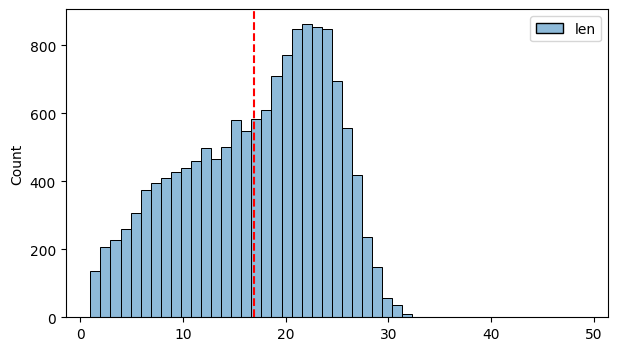

In [52]:
import seaborn as sns

query = """
select
    len
from data_shuffled
""".strip()

text_len = pysqldf(query)

plt.figure(figsize=(7, 4))
sns.histplot(text_len)
plt.axvline(x=text_len["len"].mean(), color='red', linestyle='--') # plot mean as vertical dotted red line
plt.show()

#### Train/Test assignment

In [53]:
train_idx, test_idx = train_test_split(
    pd.Series(data_shuffled.index),
    stratify=df["airline_sentiment"],
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(train_idx.shape, test_idx.shape)

data_shuffled.loc[train_idx, "split"] = "train"
data_shuffled.loc[test_idx, "split"] = "test"

(11588,) (2897,)


In [54]:
data_shuffled.head()

,tweet_id,text,airline_sentiment,text_cleaned,len,split
6525,567801645795643393,@SouthwestAir Amazing customer service as well...,positive,Amazing customer service as well Will definite...,18,train
5485,568951064688373760,@SouthwestAir thanks for an awesome flight and...,positive,thanks for an awesome flight and connection We...,18,train
14129,569642306640306176,@AmericanAir Am on web site requesting refund ...,neutral,Am on web site requesting refund for Cancelled...,18,train
5473,568962547891736576,@SouthwestAir booked the 8th.... Save me an em...,neutral,booked the 8th Save me an emergency exit Got t...,12,train
8088,568800822693380096,@JetBlue I’m going to miss a hugely important ...,negative,I ’m going to miss a hugely important meeting ...,15,test


In [59]:
query = """
select
    split
    , count(*) as cnt
from data_shuffled
group by 1
order by 1
""".strip()

pysqldf(query)

,split,cnt
0,test,2897
1,train,11588


In [56]:
query = """
with t1 as (
select
    split
    , airline_sentiment
    , count(*) as cnt
from data_shuffled
group by 1, 2
)

, t2 as (
select
 *
 , sum(cnt) over (partition by split) as total
from t1
)

select
    *
    , round(cast(cnt as float) / total * 100, 2) as prc
from t2
order by airline_sentiment, split
""".strip()

pysqldf(query)

,split,airline_sentiment,cnt,total,prc
0,test,negative,1773,2897,61.20
1,train,negative,7309,11588,63.07
2,test,neutral,655,2897,22.61
3,train,neutral,2414,11588,20.83
4,test,positive,469,2897,16.19
5,train,positive,1865,11588,16.09


#### Prepare data for Spacy text classification model

In [60]:
data_preprocessed = []

for index, row in data_shuffled.iterrows():
    text = row["text_cleaned"]
    label = {row["airline_sentiment"]: True}
    split = row["split"]
    
    data_preprocessed.append([text, label, split])

data_preprocessed[:5]

[['Amazing customer service as well Will definitely fly with you guys again if my instrument is involved 10/10',
  {'positive': True},
  'train'],
 ['thanks for an awesome flight and connection We were delayed but your staff and crew were purely amazing',
  {'positive': True},
  'train'],
 ['Am on web site requesting refund for Cancelled Flightled flight It requires numerical document number Where get it',
  {'neutral': True},
  'train'],
 ['booked the 8th Save me an emergency exit Got ta stretch out',
  {'neutral': True},
  'train'],
 ['I ’m going to miss a hugely important meeting because of your constant delays itscostingmeincome',
  {'negative': True},
  'test']]

#### Train/Test Split

In [61]:
train_data = [x[:-1] for x in data_preprocessed if x[-1] == "train"]
test_data = [x[:-1] for x in data_preprocessed if x[-1] == "test"]

print(len(train_data), len(test_data))

11588 2897


### Baseline
Assuming a baseline model that always predicts the most frequent class in the train data.
In this case, the most frequent label is the `negative` class.
The baseline accuracy represents the lower bound that any more complex approach should top to justify its application in a production environment.

              precision    recall  f1-score   support

    negative       0.61      1.00      0.76      1773
     neutral        nan      0.00       nan       655
    positive        nan      0.00       nan       469

    accuracy                           0.61      2897
   macro avg       0.61      0.33      0.76      2897
weighted avg       0.61      0.61      0.76      2897



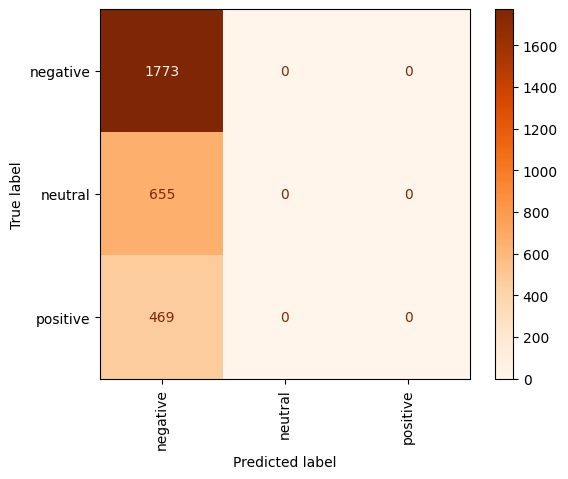

In [81]:
pred_labels = ["negative"] * len(test_data)
target_labels = [list(x[1].keys())[0] for x in test_data]

print(classification_report(target_labels, pred_labels, zero_division=np.nan))
plot_confmatrix(target_labels, pred_labels)

### TextCatEnsemble

#### Train

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 43.3944 | Train Acc: 85.66% | Test Acc: 76.87%


  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 25.2348 | Train Acc: 92.56% | Test Acc: 77.70%


  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 14.4965 | Train Acc: 96.98% | Test Acc: 76.46%


  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 8.6727 | Train Acc: 97.97% | Test Acc: 75.70%


  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 6.8252 | Train Acc: 98.54% | Test Acc: 76.42%


  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 4.9728 | Train Acc: 98.75% | Test Acc: 75.35%


  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 4.5224 | Train Acc: 98.91% | Test Acc: 76.91%


  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 3.7965 | Train Acc: 98.89% | Test Acc: 76.01%


  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 3.4991 | Train Acc: 99.02% | Test Acc: 76.29%


  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 3.3098 | Train Acc: 99.09% | Test Acc: 77.29%


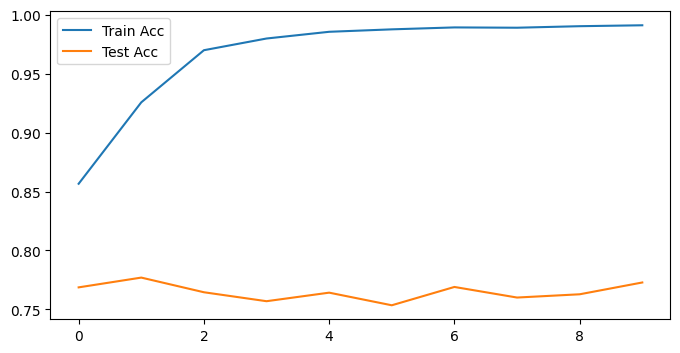

In [74]:
pipe_ensemble = init_pipe(single_label_default_config, labels)
pipe_ensemble_trained, info = train(pipe_ensemble, train_data, test_data, batch_size=32, epochs=10)
plot_accuracy(info)

#### Evaluation

              precision    recall  f1-score   support

    negative       0.82      0.91      0.86      1773
     neutral       0.65      0.50      0.57       655
    positive       0.70      0.65      0.67       469

    accuracy                           0.77      2897
   macro avg       0.72      0.68      0.70      2897
weighted avg       0.76      0.77      0.76      2897



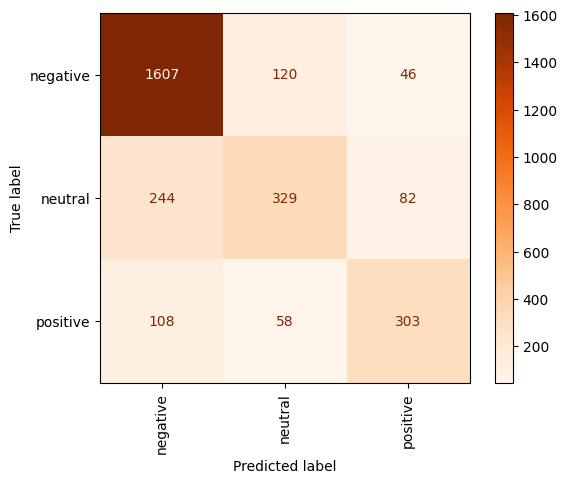

In [75]:
pred_labels = predict(pipe_ensemble_trained, test_data)
target_labels = [list(x[1].keys())[0] for x in test_data]

print(classification_report(target_labels, pred_labels))
plot_confmatrix(target_labels, pred_labels)

### TextCatBOW

#### Train

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 49.4505 | Train Acc: 82.00% | Test Acc: 76.49%


  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 34.9523 | Train Acc: 86.88% | Test Acc: 78.46%


  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 28.5754 | Train Acc: 89.54% | Test Acc: 79.60%


  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 24.4421 | Train Acc: 91.18% | Test Acc: 80.22%


  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 21.4020 | Train Acc: 92.40% | Test Acc: 80.15%


  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 19.1394 | Train Acc: 93.48% | Test Acc: 80.32%


  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 17.2498 | Train Acc: 94.23% | Test Acc: 79.77%


  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 15.6747 | Train Acc: 94.85% | Test Acc: 79.94%


  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 14.3847 | Train Acc: 95.28% | Test Acc: 79.60%


  0%|          | 0/363 [00:00<?, ?it/s]

[INFO] Train Loss: 13.2273 | Train Acc: 95.79% | Test Acc: 79.39%


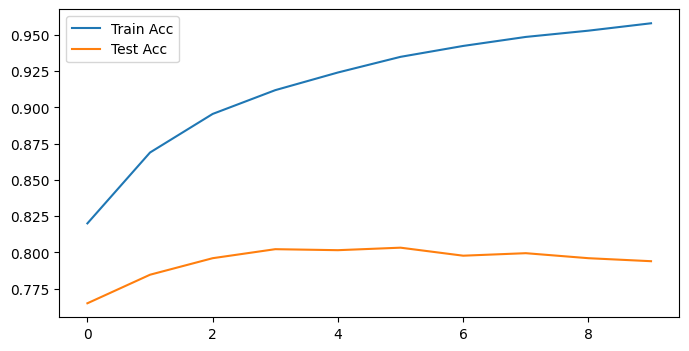

In [71]:
pipe_bow = init_pipe(single_label_bow_config, labels)
pipe_bow_trained, info = train(pipe_bow, train_data, test_data, batch_size=32, epochs=10, drop_prc=0.3)
plot_accuracy(info)

#### Evaluation

              precision    recall  f1-score   support

    negative       0.85      0.90      0.87      1773
     neutral       0.66      0.59      0.62       655
    positive       0.74      0.68      0.71       469

    accuracy                           0.79      2897
   macro avg       0.75      0.72      0.74      2897
weighted avg       0.79      0.79      0.79      2897



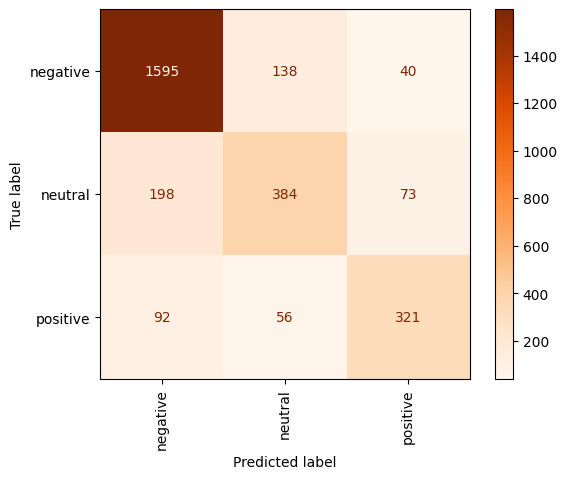

In [73]:
pred_labels = predict(pipe_bow_trained, test_data)
target_labels = [list(x[1].keys())[0] for x in test_data]

print(classification_report(target_labels, pred_labels))
plot_confmatrix(target_labels, pred_labels)

### CNN

#### Train

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

[INFO] Train Loss: 26.2318 | Train Acc: 77.80% | Test Acc: 74.21%


  0%|          | 0/182 [00:00<?, ?it/s]

[INFO] Train Loss: 19.1879 | Train Acc: 84.21% | Test Acc: 77.42%


  0%|          | 0/182 [00:00<?, ?it/s]

[INFO] Train Loss: 17.0194 | Train Acc: 84.82% | Test Acc: 76.94%


  0%|          | 0/182 [00:00<?, ?it/s]

[INFO] Train Loss: 15.0021 | Train Acc: 88.92% | Test Acc: 77.84%


  0%|          | 0/182 [00:00<?, ?it/s]

[INFO] Train Loss: 13.6621 | Train Acc: 90.46% | Test Acc: 77.70%


  0%|          | 0/182 [00:00<?, ?it/s]

[INFO] Train Loss: 12.6988 | Train Acc: 91.43% | Test Acc: 78.15%


  0%|          | 0/182 [00:00<?, ?it/s]

[INFO] Train Loss: 11.8652 | Train Acc: 91.78% | Test Acc: 78.29%


  0%|          | 0/182 [00:00<?, ?it/s]

[INFO] Train Loss: 11.0644 | Train Acc: 93.80% | Test Acc: 78.46%


  0%|          | 0/182 [00:00<?, ?it/s]

[INFO] Train Loss: 10.1742 | Train Acc: 93.92% | Test Acc: 77.36%


  0%|          | 0/182 [00:00<?, ?it/s]

[INFO] Train Loss: 9.9342 | Train Acc: 94.96% | Test Acc: 78.01%


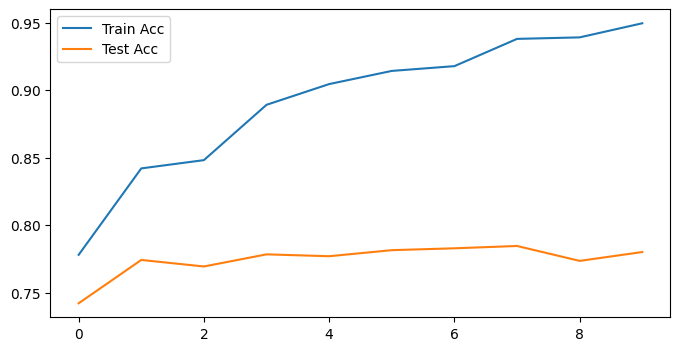

In [76]:
pipe_cnn = init_pipe(single_label_cnn_config, labels)
pipe_cnn_trained, info = train(pipe_cnn, train_data, test_data, batch_size=64, epochs=10, drop_prc=0.3)
plot_accuracy(info)

#### Evaluation

              precision    recall  f1-score   support

    negative       0.83      0.90      0.86      1773
     neutral       0.66      0.56      0.60       655
    positive       0.70      0.65      0.67       469

    accuracy                           0.78      2897
   macro avg       0.73      0.70      0.71      2897
weighted avg       0.77      0.78      0.77      2897



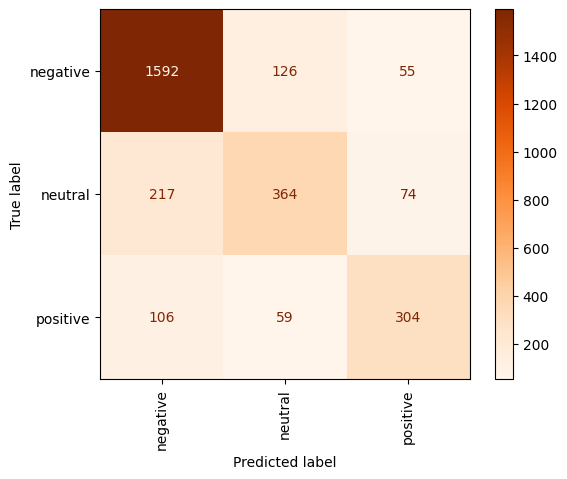

In [78]:
pred_labels = predict(pipe_cnn_trained, test_data)
target_labels = [list(x[1].keys())[0] for x in test_data]

print(classification_report(target_labels, pred_labels))
plot_confmatrix(target_labels, pred_labels)

### Conclusion
Among the ready-to-use text classification models/pipelines, the BOW-based approached was the fastest to train and the most accurate model.

### Next Step
- further clean up the data: remove tweets with less than 5 words/tokens that might not be semantically rich enough to be properly classified.
- augment tweets by including information contained in other columns.
- preprocess text using more advanced embedding models.
- hyperparameter tuning.
- use more modern ML architecture (e.g. transformer-based models) to classify text.
- perform post-training analysis: check most confused classes to potentially identify mislabelled data.